In [158]:
# Meta-learning + Random Search Hyperparameter Tuning (range-based)

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import learn2learn as l2l
from torch import optim
import random

# Set global random seed for repeatability
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load and preprocess data
df = pd.read_csv("../data/full_data.csv")
df["strainrate"] = df["strainrate"].clip(lower=1e-6)
df["strain"] = df["strain"].clip(lower=1e-6)

features = ["T", "strainrate", "strain", "porosity"]
target = "stress"

scaler_X = StandardScaler()
scaler_y = StandardScaler()
df[features] = scaler_X.fit_transform(df[features])
df[target] = scaler_y.fit_transform(df[[target]])

# Assign task_id (each porosity + T combination is a separate task)
df["task_id"] = df.apply(lambda row: f"{row['porosity']}_{row['T']}_{row['strainrate']}", axis=1)

In [159]:
def get_task_data(task_id, df, k_support=10, k_query=20):
    task_data = df[df["task_id"] == task_id]
    task_data = task_data.sample(frac=1).reset_index(drop=True)
    x = torch.tensor(task_data[features].values, dtype=torch.float32)
    y = torch.tensor(task_data[target].values, dtype=torch.float32).squeeze()
    return (x[:k_support], y[:k_support]), (x[k_support:k_support+k_query], y[k_support:k_support+k_query])

class StressRegressor(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=32, dropout_p=0.03):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

In [160]:
# Parameter ranges for random sampling
param_ranges = {
    "inner_lr": (0.001, 0.05),
    "outer_lr": (0.0001, 0.01),
    "meta_batch_size": [2, 4, 6, 8],
    "hidden_dim": [16, 32, 48, 64],
    "inner_steps": [1, 3, 5, 8],
    "num_iterations": [500, 1000, 3000],
    "support_size": [5, 10, 15, 25],
    "query_size": [5, 10, 20, 25]
}

def sample_random_config():
    return {
        "inner_lr": random.uniform(*param_ranges["inner_lr"]),
        "outer_lr": random.uniform(*param_ranges["outer_lr"]),
        "meta_batch_size": random.choice(param_ranges["meta_batch_size"]),
        "hidden_dim": random.choice(param_ranges["hidden_dim"]),
        "inner_steps": random.choice(param_ranges["inner_steps"]),
        "num_iterations": random.choice(param_ranges["num_iterations"]),
        "support_size": random.choice(param_ranges["support_size"]),
        "query_size": random.choice(param_ranges["query_size"])
    }

# Random search loop
best_params = None
lowest_mae = float('inf')
n_trials = 50
all_tasks = df["task_id"].unique()

for trial in range(n_trials):
    params = sample_random_config()
    model = StressRegressor(hidden_dim=params["hidden_dim"])
    maml = l2l.algorithms.MAML(model, lr=params["inner_lr"])
    opt = optim.Adam(maml.parameters(), lr=params["outer_lr"])

    for iteration in range(300):
        opt.zero_grad()
        meta_loss = 0.0
        selected_tasks = np.random.choice(all_tasks, size=params["meta_batch_size"], replace=True)
        for task_id in selected_tasks:
            learner = maml.clone()
            (x_spt, y_spt), (x_qry, y_qry) = get_task_data(task_id, df, k_support=params["support_size"], k_query=params["query_size"])
            for _ in range(params["inner_steps"]):
                spt_loss = F.mse_loss(learner(x_spt), y_spt)
                learner.adapt(spt_loss)
            qry_loss = F.mse_loss(learner(x_qry), y_qry)
            meta_loss += qry_loss
        meta_loss /= params["meta_batch_size"]
        meta_loss.backward()
        opt.step()

    # Evaluate on held-out task
    learner = maml.clone()
    test_task = all_tasks[0]
    (x_spt, y_spt), (x_qry, y_qry) = get_task_data(test_task, df, k_support=params["support_size"], k_query=params["query_size"])
    for _ in range(params["inner_steps"]):
        learner.adapt(F.mse_loss(learner(x_spt), y_spt))
    with torch.no_grad():
        preds = learner(x_qry)
    mae = F.l1_loss(preds, y_qry).item()

    print(f"Trial {trial+1}: MAE = {mae:.4f}, Params = {params}")
    if mae < lowest_mae:
        best_params = params
        lowest_mae = mae

print("\nBest Parameters:", best_params)
print("Lowest MAE:", lowest_mae)

Trial 1: MAE = 0.1628, Params = {'inner_lr': 0.032331913124436305, 'outer_lr': 0.00034760647670440266, 'meta_batch_size': 6, 'hidden_dim': 32, 'inner_steps': 3, 'num_iterations': 500, 'support_size': 5, 'query_size': 5}
Trial 2: MAE = 0.4808, Params = {'inner_lr': 0.029934133110002946, 'outer_lr': 0.0004146485268696576, 'meta_batch_size': 2, 'hidden_dim': 32, 'inner_steps': 3, 'num_iterations': 3000, 'support_size': 5, 'query_size': 10}
Trial 3: MAE = 0.0816, Params = {'inner_lr': 0.03608496103319777, 'outer_lr': 0.007043117238543337, 'meta_batch_size': 8, 'hidden_dim': 32, 'inner_steps': 8, 'num_iterations': 3000, 'support_size': 15, 'query_size': 5}
Trial 4: MAE = 0.0969, Params = {'inner_lr': 0.0381815609893586, 'outer_lr': 0.0016806272321312123, 'meta_batch_size': 8, 'hidden_dim': 48, 'inner_steps': 5, 'num_iterations': 500, 'support_size': 10, 'query_size': 20}
Trial 5: MAE = 0.0697, Params = {'inner_lr': 0.006008303549472587, 'outer_lr': 0.00386128027630964, 'meta_batch_size': 6,

In [161]:
# Final training with best params
model = StressRegressor(hidden_dim=best_params["hidden_dim"])
maml = l2l.algorithms.MAML(model, lr=best_params["inner_lr"])
opt = optim.Adam(maml.parameters(), lr=best_params["outer_lr"])

for iteration in range(best_params["num_iterations"]):
    opt.zero_grad()
    meta_loss = 0.0
    selected_tasks = np.random.choice(all_tasks, size=best_params["meta_batch_size"], replace=True)
    for task_id in selected_tasks:
        learner = maml.clone()
        (x_spt, y_spt), (x_qry, y_qry) = get_task_data(task_id, df, k_support=best_params["support_size"], k_query=best_params["query_size"])
        for _ in range(best_params["inner_steps"]):
            spt_loss = F.mse_loss(learner(x_spt), y_spt)
            learner.adapt(spt_loss)
        qry_loss = F.mse_loss(learner(x_qry), y_qry)
        meta_loss += qry_loss
    meta_loss /= best_params["meta_batch_size"]
    meta_loss.backward()
    opt.step()
    if iteration % 100 == 0:
        print(f"Iter {iteration}: Meta-loss = {meta_loss.item():.4f}")

Iter 0: Meta-loss = 0.2204
Iter 100: Meta-loss = 0.0086
Iter 200: Meta-loss = 0.0043
Iter 300: Meta-loss = 0.0106
Iter 400: Meta-loss = 0.0045
Iter 500: Meta-loss = 0.0028
Iter 600: Meta-loss = 0.0091
Iter 700: Meta-loss = 0.0090
Iter 800: Meta-loss = 0.0064
Iter 900: Meta-loss = 0.0027


In [162]:
# Predictive wrapper remains the same as before...

def predict_stress_curve_meta(
    porosity_value, 
    T_value=400, 
    rate_value=2000, 
    strain_step=0.005, 
    n_forward_passes=50
):
    # 1. Generate test data 
    strain_range = np.arange(0.01, 0.25, strain_step)
    test_df = pd.DataFrame({
        "T": T_value,
        "strainrate": rate_value,
        "strain": strain_range,
        "porosity": porosity_value
    })
    X_test_scaled = scaler_X.transform(test_df)
    X_test = torch.tensor(X_test_scaled, dtype=torch.float32)

    # 2. Get support set, and train a learner
    task_id = f"{porosity_value}_{T_value}_{rate_value}"  # task_id includes strainrate
    (x_spt, y_spt), _ = get_task_data(task_id, df)

    learner = maml.clone()

    for _ in range(best_params["inner_steps"]):
        spt_loss = F.mse_loss(learner(x_spt), y_spt)
        learner.adapt(spt_loss)

    # 3. MC Dropout Inference（Start Dropout, repeat multiple forward）
    learner.train()  # start dropout
    preds_list = []

    for _ in range(n_forward_passes):
        with torch.no_grad():
            preds = learner(X_test).numpy()
            preds_rescaled = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()
            preds_list.append(preds_rescaled)

    preds_array = np.stack(preds_list)  # shape = (n_forward_passes, n_points)

    # 4. Calculate mean, std for 95% CI
    stress_median = np.mean(preds_array, axis=0)
    stress_std = np.std(preds_array, axis=0)
    stress_lower = stress_median - 2 * stress_std
    stress_upper = stress_median + 2 * stress_std

    # 5. Insert origin (0, 0)
    strain_range = np.insert(strain_range, 0, 0.0)
    stress_median = np.insert(stress_median, 0, 0.0)
    stress_lower = np.insert(stress_lower, 0, 0.0)
    stress_upper = np.insert(stress_upper, 0, 0.0)

    return strain_range, stress_median, stress_lower, stress_upper


In [170]:
def plot_meta_curve(porosity_value, T_value=400, rate_value=2000):
    strain_range, stress_median, stress_lower, stress_upper = predict_stress_curve_meta(
        porosity_value=porosity_value,
        T_value=T_value,
        rate_value=rate_value
    )

    plt.figure(figsize=(7, 5))
    plt.plot(strain_range, stress_median, label="Meta Median Prediction", color="green")
    plt.fill_between(strain_range, stress_lower, stress_upper,
                     alpha=0.3, label="MC Dropout Uncertainty", color="pink")
    plt.xlabel("Strain")
    plt.ylabel("Stress (MPa)")
    plt.title(f"Meta-Learning Stress-Strain Curve (Porosity = {porosity_value})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


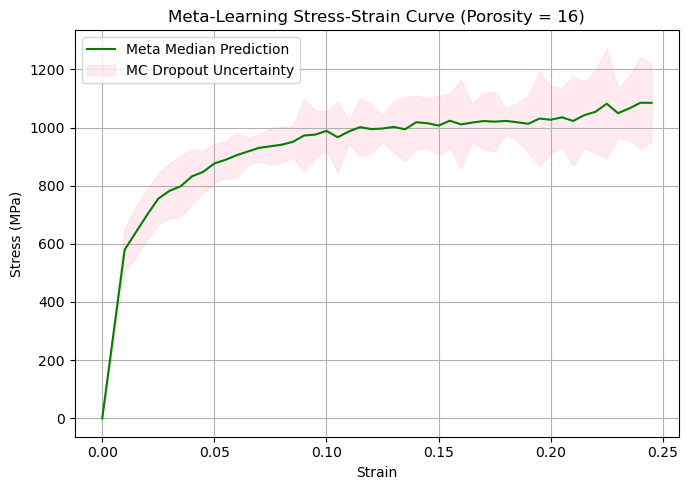

In [171]:
# Example
plot_meta_curve(porosity_value=16, T_value=300, rate_value=4500)